# UW Live Ocean Data


http://faculty.washington.edu/pmacc/LO/LiveOcean.html

> LiveOcean works a lot like the weather forecast models that we all rely on every day. It takes in information about the state of the ocean, atmosphere and rivers on a given day, and then uses the laws of physics (and a large computer) to predict how the state of the ocean in our region will change over the next few days. The things that the model predicts are currents, salinity, temperature, chemical concentrations of nitrate, oxygen, carbon, and biological fields like phytoplankton, zooplankton, and organic particles. It does this in three dimensions, and allowing continuous variation over the full 72 hour forecast it makes every day.

- [How the Model Works](http://faculty.washington.edu/pmacc/LO/how_it_works.html)

> The model framework we use is called the Regional Ocean Modeling System (ROMS) which is a large, flexible computer code that is used by coastal and estuarine oceanographers around the world to simulate different regions. It is known to have excellent numerical properties, such as low numerical diffusion, many choices for turbulence parameterization and open boundary conditions, built-in biogeochemical models, and a large, active user community. We have been using ROMS for realistic simulations in the region for research projects for the past decade and have found it to be a robust tool.

Its based on the [ROMS Finite Element Model](https://www.myroms.org/)

- [Awesome Accessible Description of Tides](http://faculty.washington.edu/pmacc/LO/tides_background.html)


In [1]:
# Basics
import os
import copy
import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import numpy.ma as ma
from numba import jit

import netCDF4
import cv2

In [2]:
# These are libraries written for RegattaAnalysis
from global_variables import G  # global variables

In [3]:
from latlonalt import LatLonAlt as lla
import utils
from utils import DictClass

import race_logs                # load data from races

In [4]:
# %matplotlib notebook

In [5]:
import nbutils
from nbutils import display_markdown, display

In [6]:
# notebook - initialize
# nbutils.matplotlib_notebook()

G.init_seattle()

In [ ]:
import arrow

UW_URL = "https://pm2.blob.core.windows.net/f20200520/ocean_surface.nc"
UW_BASE = "https://pm2.blob.core.windows.net/:
UW_FILE = "ocean_surface.nc"

def fectch_uw_model(date):
    adt = arrow.get(date)
    directory = f"f{adt.month:04d}{adt}
    url = UW_URL + 
    

In [7]:
# I was able to grab an NC file from:
# https://pm2.blob.core.windows.net/f20200520/ocean_surface.nc
#
# From: Parker MacCready <p.maccready@gmail.com>
# It has the surface currents (u,v) for all 73 hours of today's forecast on the 
# lon_rho, lat_rho grid.  New ones appear every day by around 8 AM.

data_dir = "/Users/viola/BigData"
model_file = "2020-05-22_ocean_surface.nc"

ncdf_ocean = netCDF4.Dataset(os.path.join(data_dir, model_file))

In [8]:
# This a function cribbed from link sort of verbose but handy.
# http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html#code

def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr, repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim )
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [9]:
def to_datetime(seconds):
    "Convenience to convert ncdf times to datetimes."
    epoch = datetime.datetime.utcfromtimestamp(0)
    dt = epoch + datetime.timedelta(0, seconds) 
    return dt

In [10]:
# Let's see what is in the file (as advertized it is very similar to ncdump)
ncdump(ncdf_ocean)

NetCDF Global Attributes:
NetCDF dimension information:
	Name: xi_rho
		size: 663
	Name: xi_psi
		size: 662
	Name: eta_rho
		size: 1302
	Name: eta_psi
		size: 1301
	Name: ocean_time
		size: 37
		type: dtype('float64')
		long_name: 'time since initialization'
		units: 'seconds since 1970-01-01 00:00:00'
NetCDF variable information:
	Name: lon_rho
		dimensions: ('eta_rho', 'xi_rho')
		size: 863226
		type: dtype('float64')
		long_name: 'longitude of RHO-points'
		units: 'degree_east'
		standard_name: 'longitude'
		field: 'lon_rho, scalar'
	Name: lat_rho
		dimensions: ('eta_rho', 'xi_rho')
		size: 863226
		type: dtype('float64')
		long_name: 'latitude of RHO-points'
		units: 'degree_north'
		standard_name: 'latitude'
		field: 'lat_rho, scalar'
	Name: lon_psi
		dimensions: ('eta_psi', 'xi_psi')
		size: 861262
		type: dtype('float64')
		long_name: 'longitude of PSI-points'
		units: 'degree_east'
		standard_name: 'longitude'
		field: 'lon_psi, scalar'
	Name: lat_psi
		dimensions: ('eta_psi', 

([],
 ['xi_rho', 'xi_psi', 'eta_rho', 'eta_psi', 'ocean_time'],
 ['lon_rho',
  'lat_rho',
  'lon_psi',
  'lat_psi',
  'mask_rho',
  'h',
  'Uwind',
  'Vwind',
  'ocean_time',
  'salt',
  'temp',
  'u',
  'v'])

### NetCDF is self documenting.

We are specifically interested in U,V which are the current predictions in m/s (note, it does not say current, but Parker's email points this out).  

We are likely also interested in Uwind and Vwind (if they turn out to be more accurate than other local predictions).  **But are these inputs to the ocean model, or outputs?** And if inputs, from what model?

NetCDF is a gridded representation.  In this case the "data" is triple indexed
by `('ocean_time', 'eta_rho', 'xi_rho')`.

But what does this mean?  The data is on a fixed grid indexed by integers, but the **meaning** of that grid location is held in the associated variables.

In [11]:
display_markdown("## Meaning of the index variables.")

for name in "ocean_time lon_rho lat_rho".split():
    display_markdown(f"### {name}")
    display(ncdf_ocean.variables[name])
    display(ncdf_ocean.variables[name][:])

ocean_time = ncdf_ocean.variables['ocean_time'][:]
lon_rho = ncdf_ocean.variables['lon_rho'][:]
lat_rho = ncdf_ocean.variables['lat_rho'][:]

[to_datetime(ot) for ot in ocean_time]

## Meaning of the index variables.

### ocean_time

<class 'netCDF4._netCDF4.Variable'>
float64 ocean_time(ocean_time)
    long_name: time since initialization
    units: seconds since 1970-01-01 00:00:00
unlimited dimensions: ocean_time
current shape = (37,)
filling on, default _FillValue of 9.969209968386869e+36 used

masked_array(data=[1.5901056e+09, 1.5901128e+09, 1.5901200e+09,
                   1.5901272e+09, 1.5901344e+09, 1.5901416e+09,
                   1.5901488e+09, 1.5901560e+09, 1.5901632e+09,
                   1.5901704e+09, 1.5901776e+09, 1.5901848e+09,
                   1.5901920e+09, 1.5901992e+09, 1.5902064e+09,
                   1.5902136e+09, 1.5902208e+09, 1.5902280e+09,
                   1.5902352e+09, 1.5902424e+09, 1.5902496e+09,
                   1.5902568e+09, 1.5902640e+09, 1.5902712e+09,
                   1.5902784e+09, 1.5902856e+09, 1.5902928e+09,
                   1.5903000e+09, 1.5903072e+09, 1.5903144e+09,
                   1.5903216e+09, 1.5903288e+09, 1.5903360e+09,
                   1.5903432e+09, 1.5903504e+09, 1.5903576e+09,
                   1.5903648e+09],
             mask=False,
       fill_value=1e+20)

### lon_rho

<class 'netCDF4._netCDF4.Variable'>
float64 lon_rho(eta_rho, xi_rho)
    long_name: longitude of RHO-points
    units: degree_east
    standard_name: longitude
    field: lon_rho, scalar
unlimited dimensions: 
current shape = (1302, 663)
filling on, default _FillValue of 9.969209968386869e+36 used

masked_array(
  data=[[-129.97980154, -129.93956155, -129.89963416, ..., -122.01530033,
         -122.00856751, -122.00183469],
        [-129.97980154, -129.93956155, -129.89963416, ..., -122.01530033,
         -122.00856751, -122.00183469],
        [-129.97980154, -129.93956155, -129.89963416, ..., -122.01530033,
         -122.00856751, -122.00183469],
        ...,
        [-129.97980154, -129.93956155, -129.89963416, ..., -122.01530033,
         -122.00856751, -122.00183469],
        [-129.97980154, -129.93956155, -129.89963416, ..., -122.01530033,
         -122.00856751, -122.00183469],
        [-129.97980154, -129.93956155, -129.89963416, ..., -122.01530033,
         -122.00856751, -122.00183469]],
  mask=False,
  fill_value=1e+20)

### lat_rho

<class 'netCDF4._netCDF4.Variable'>
float64 lat_rho(eta_rho, xi_rho)
    long_name: latitude of RHO-points
    units: degree_north
    standard_name: latitude
    field: lat_rho, scalar
unlimited dimensions: 
current shape = (1302, 663)
filling on, default _FillValue of 9.969209968386869e+36 used

masked_array(
  data=[[42.00674984, 42.00674984, 42.00674984, ..., 42.00674984,
         42.00674984, 42.00674984],
        [42.02023737, 42.02023737, 42.02023737, ..., 42.02023737,
         42.02023737, 42.02023737],
        [42.03370062, 42.03370062, 42.03370062, ..., 42.03370062,
         42.03370062, 42.03370062],
        ...,
        [51.95637768, 51.95637768, 51.95637768, ..., 51.95637768,
         51.95637768, 51.95637768],
        [51.98303063, 51.98303063, 51.98303063, ..., 51.98303063,
         51.98303063, 51.98303063],
        [52.00989524, 52.00989524, 52.00989524, ..., 52.00989524,
         52.00989524, 52.00989524]],
  mask=False,
  fill_value=1e+20)

[datetime.datetime(2020, 5, 22, 0, 0),
 datetime.datetime(2020, 5, 22, 2, 0),
 datetime.datetime(2020, 5, 22, 4, 0),
 datetime.datetime(2020, 5, 22, 6, 0),
 datetime.datetime(2020, 5, 22, 8, 0),
 datetime.datetime(2020, 5, 22, 10, 0),
 datetime.datetime(2020, 5, 22, 12, 0),
 datetime.datetime(2020, 5, 22, 14, 0),
 datetime.datetime(2020, 5, 22, 16, 0),
 datetime.datetime(2020, 5, 22, 18, 0),
 datetime.datetime(2020, 5, 22, 20, 0),
 datetime.datetime(2020, 5, 22, 22, 0),
 datetime.datetime(2020, 5, 23, 0, 0),
 datetime.datetime(2020, 5, 23, 2, 0),
 datetime.datetime(2020, 5, 23, 4, 0),
 datetime.datetime(2020, 5, 23, 6, 0),
 datetime.datetime(2020, 5, 23, 8, 0),
 datetime.datetime(2020, 5, 23, 10, 0),
 datetime.datetime(2020, 5, 23, 12, 0),
 datetime.datetime(2020, 5, 23, 14, 0),
 datetime.datetime(2020, 5, 23, 16, 0),
 datetime.datetime(2020, 5, 23, 18, 0),
 datetime.datetime(2020, 5, 23, 20, 0),
 datetime.datetime(2020, 5, 23, 22, 0),
 datetime.datetime(2020, 5, 24, 0, 0),
 datetime.d

In [12]:
# Similarly we can extract the actual current data:

current_n = ncdf_ocean.variables['v'][:, :, :]
current_e = ncdf_ocean.variables['u'][:, :, :]
im = current_n[0, :, :]
display(im)
display(im.shape)

masked_array(
  data=[[nan, nan, nan, ..., --, --, --],
        [-0.0319674089550972, -0.026699412614107132,
         -0.022683242335915565, ..., --, --, --],
        [-0.034095436334609985, -0.020202934741973877,
         -0.025975218042731285, ..., --, --, --],
        ...,
        [0.02355128712952137, -0.042203161865472794,
         -0.03827676922082901, ..., --, --, --],
        [0.044674649834632874, 0.022389210760593414, 0.07994437962770462,
         ..., --, --, --],
        [nan, nan, nan, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=9.969209968386869e+36)

(1302, 663)

### Note that the array is masked. 

https://numpy.org/doc/stable/reference/maskedarray.generic.html

And this makes sense, since the value of the current is not defined on land, etc."

Note, `True` implies that the data is **NOT** valid.

And conveniently matplotlib handles masked array directly.

<IPython.core.display.Javascript object>


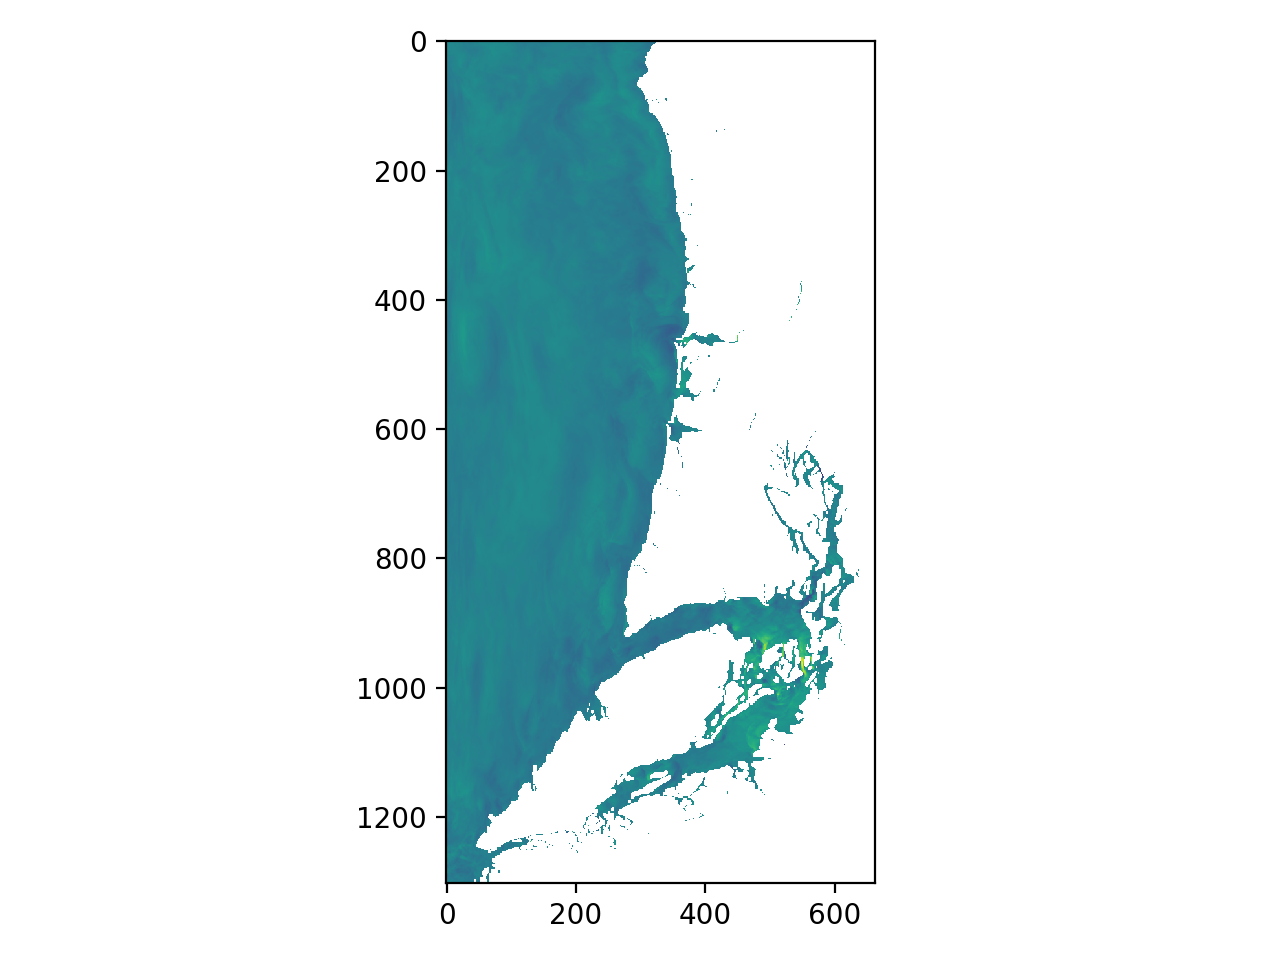

In [13]:
fig, ax = plt.subplots(1, 1, num=None)
fig.tight_layout()
ax.imshow(im)

### What is going on with this?

Looking at the image, it appears to be corrupted.  Its not.  (While it is ultimately not important, you can "see" the map if you flip it vertically and then ignore the distortion.  Seattle is at roughly x=602, y=745.)

Remember that each pixel in the image is the current value at a particular time and location. 

In [ ]:
i = 0
j = 745
k = 602
display(f"Northward current is: {current_n[i, j, k]}")  # is the value at 
display(f"time = {to_datetime(ocean_time[i]).isoformat()}")
display(f"longitude = {lon_rho[j, k]}")
display(f"latitude = {lat_rho[j, k]}")

display("Lat/Lon of Seattle is: 47.6062° N, 122.3321° W")

In [ ]:
# We can convert these lat/lon coordinate to a local projection using Pyproj.  

east, north = G.MAP(lon_rho, lat_rho)  # Works great with numpy masked arrays.

# The result is in meters east from our center of projection.
east

### Visualizing Data

We now have a subtle problem, the data is not really an image.  There are parts of the map where the sampling coarse and others where it is fine (there are more pixels in some places and less others).  We can perform a quick hack to turn this into an image as follows:

In [ ]:
# Compute an image, in our projected coordinates, where the value of the pixel is 
# determined by mapping the lat/lon coordinate into pixel coordinates.
#
# Resulting image is 2*size x 2*size.  Do not process points which are more than 
# threshold distance away in east or north.
#
# For any given image, there are likely to be holes.

def forward_map(east, north, values, threshold, size):
    res = np.zeros((2+size*2, 2+size*2))
    mask = np.ones(res.shape, np.bool)
    forward_map_helper(east, north, values.data, values.mask, res, mask, threshold, size)
    return ma.array(data=res, mask=mask)

@jit(nopython=True)
def forward_map_helper(east, north, values, values_mask, res, mask, threshold, size):
    height, width = east.shape
    for c in range(width):
        for r in range(height):
            if np.abs(east[r, c]) < threshold and np.abs(north[r, c]) < threshold:
                x = int(1 + size + size * east[r, c]/threshold)
                y = int(1 + size + -size * north[r, c]/threshold)
                if not values_mask[r, c]:
                    res[y, x] = values[r, c]
                    mask[y, x] = False

In [ ]:
dist = 40000
res = forward_map(east, north, im, dist, 200)

plt.figure()
plt.imshow(res, extent=[-dist, dist, -dist, dist])

dist = 40000
res = forward_map(east, north, im, dist, 75)

plt.figure()
plt.imshow(res, extent=[-dist, dist, -dist, dist])


### Looks like Seattle, but notice the holes

Specifically zoom in on the higher resolution image.  The Live Ocean data is 0.5km.  When the image resolution is higher than 0.5km then there are pixels where there is no estimate.  Using a lower resolution image (second image) fills in the gaps, but it is unnecessarily coarse.

Note, ultimately these images are not particularly useful.  But it does show the structure of the underlying data.

We can also fill in the holes, using a blend of nearby pixels.  Note, this does a nice job **except** near the coastline, where it blurs things (it is unaware of the coast).

In [ ]:
def gaussian_kernel(kernel_size, sigma):
    kernel = np.zeros((kernel_size, kernel_size))
    middle = np.int(kernel_size/2)
    for c in range(kernel_size):
        for r in range(kernel_size):
            d = np.square(c - middle) + np.square(r - middle)
            kernel[c, r] = np.exp(-sigma * d/np.square(middle))
    return kernel

def image_fill(image, kernel_size):
    "Fill in missing values in image by taking a weighted blend of nearby pixels."
    kernel = gaussian_kernel(kernel_size, 1.5)
    res = np.zeros(image.shape)
    mask = np.ones(res.shape, np.bool)
    image_fill_helper(image.data, image.mask, res, mask, kernel)
    return ma.array(data=res, mask=mask)
                    
@jit(nopython=True)
def image_fill_helper(image, mask, res, res_mask, kernel):
    height, width = image.shape
    size = kernel.shape[0]
    delta = np.int(size/2)
    for c in range(delta+1, width-(delta+1)):
        for r in range(delta+1, height-(delta+1)):
            if mask[r, c]:
                s = 0
                w = 0
                for dc in range(-delta, size-delta):
                    for dr in range(-delta, size-delta):
                        if not mask[dr+r, dc+c]:
                            w += kernel[dr, dc]
                            s += image[dr+r, dc+c] * kernel[dr, dc]
                if w > 0:
                    res[r, c] = s/w
                    res_mask[r, c] = False
            else:
                res[r, c] = image[r, c]
                res_mask[r, c] = False

In [ ]:
dist = 40000
res = forward_map(east, north, im, dist, 1000)
filled = image_fill(res, 13)

plt.figure()
plt.imshow(filled, extent=[-dist, dist, -dist, dist])

### 

In [ ]:
def lor(a, *b):
    res = a
    for e in b:
        res = np.logical_or(res, e)
    return res

dist = 15000
scale = 1500

maske = lor(east < -dist, east > dist)
maskn = lor(north < -dist, north > dist)

for time in range(0, 1, 1):
    u = scale * current_e[time, :, :]
    v = scale * current_n[time, :, :]

    mask = np.logical_not(lor(maske, maskn, u.mask, v.mask))
    display(to_datetime(ocean_time[time]).isoformat())

    plt.figure()
    plt.quiver(east[mask], north[mask], u[mask], v[mask], 
               angles='xy', scale_units='xy', scale=1)
    plt.axis('equal')


In [ ]:
east.shape

In [ ]:
for j in range(10):
    i = j + 300
    display((east[i,i], north[i, i], lon_rho[i,i], lat_rho[i, i]))

In [ ]:
import chart

def example_race(date="2019-11-16"):
    dfs, races, big_df = race_logs.read_dates([date], race_trim=False)
    display(races)
    return dfs[0]

df = example_race("2020-05-09")


In [ ]:
mm = np.logical_not(lor(maske, maskn))

region = DictClass(lat_max=lat_rho[mm].max(), lat_min=lat_rho[mm].min(),
                   lon_min=lon_rho[mm].min(), lon_max=lon_rho[mm].max())
region

In [ ]:
import importlib
importlib.reload(chart)

In [ ]:

time = 11
if True:
    u = scale * current_e[time, :, :]
    v = scale * current_n[time, :, :]

    mask = np.logical_not(lor(maske, maskn, u.mask, v.mask))
    adt = arrow.get(to_datetime(ocean_time[time]))
    display(adt.to('US/Pacific'))


In [ ]:
import arrow
t1 = arrow.get('2020-05-09 13:00:00.00-07:00').datetime
t2 = arrow.get('2020-05-09 14:15:00.00-07:00').datetime

tdf = df.loc[(df.row_times > t1) & (df.row_times < t2)]


ch = chart.plot_chart(df)
chart.draw_track(tdf, ch, color='red')
ch.ax.quiver(east[mask], north[mask], u[mask], v[mask], 
            angles='xy', scale_units='xy', scale=1, color='blue')
ch.fig.tight_layout()

In [ ]:
ll_mask = lor(lat_rho > ch.lat_max, lat_rho < ch.lat_min)
ll_mask = lor(ll_mask, lon_rho > ch.lon_max, lon_rho < ch.lon_min)

for time in [20, 21, 22, 23]:
    u = scale * current_e[time, :, :]
    v = scale * current_n[time, :, :]

    mask = np.logical_not(lor(ll_mask, maske, maskn, u.mask, v.mask))
    adt = arrow.get(to_datetime(ocean_time[time]))
    display(adt.to('US/Pacific'))
    
    ch = chart.create_chart(ch)
    ch.fig = plt.figure(figsize=(8, 10))
    ch.ax = ch.fig.add_subplot(111)   
    ch = chart.draw_chart(ch, ch.ax)
    ch.ax.quiver(east[mask], north[mask], u[mask], v[mask], 
                angles='xy', scale_units='xy', scale=1, color='red')
    ch.ax.set_title(model_file + " : " + str(adt.to('US/Pacific')))
    ch.fig.tight_layout()

    ch.fig.savefig("tide_" + str(adt.to('US/Pacific'))+".pdf", orientation='portrait')

In [ ]:
print(np.array((v[mask].max(), v[mask].min()))/scale)
print(scale)


In [ ]:
plt.close('all')

In [ ]:

time = 20
if True:
    u = scale * current_e[time, :, :]
    v = scale * current_n[time, :, :]

    mask = np.logical_not(lor(maske, maskn, u.mask, v.mask))
    display(to_datetime(ocean_time[time]).isoformat())

    
ch = chart.create_chart(region)
ch.fig = plt.figure(figsize=(8, 8))
ch.ax = ch.fig.add_subplot(111)   
ch = chart.draw_chart(ch, ch.ax)
ch.ax.quiver(east[mask], north[mask], u[mask], v[mask], 
            angles='xy', scale_units='xy', scale=1, color='red')



In [ ]:
region

In [ ]:
import itertools as it
[(i, to_datetime(ot)) for i, ot in enumerate(ocean_time)]